# Introduction to Customer Segmentation for a Bank Dataset using RFM Analysis

Customer segmentation is a vital process for banks to understand the different behaviors and value propositions of their customers. By effectively segmenting customers, banks can deliver more targeted services, improve customer satisfaction, and enhance profitability. One widely-used method for segmentation is **RFM analysis**, which evaluates customers based on three key dimensions: Recency, Frequency, and Monetary value.

In this project, we perform an in-depth **Exploratory Data Analysis (EDA)** to uncover trends and patterns in the bank's customer base. Following the EDA, we will apply **RFM analysis** to score customers based on:

- **Recency (R):** How recently a customer has transacted.
- **Frequency (F):** How often they have transacted within a certain period.
- **Monetary (M):** The total amount spent by the customer.

By computing these RFM scores, we can assign customers into different segments. This segmentation will help the bank in tailoring its marketing strategies and customer relationship management, ensuring targeted actions that align with the specific needs of each customer group.


## Data import and configurations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from datetime import datetime

pd.set_option('display.float_format', '{:.2f}'.format)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)


In [2]:
data = pd.read_csv("/kaggle/input/bank-customer-segmentation/bank_transactions.csv")

In [3]:
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.00
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.00
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.00
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.00
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.50


In [4]:
data.columns

Index(['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender',
       'CustLocation', 'CustAccountBalance', 'TransactionDate',
       'TransactionTime', 'TransactionAmount (INR)'],
      dtype='object')

## EDA and Feature extraction

We will create some insightfull features while also doing the exploratory Data analysis on the same features.

### a) Time-based Features

#### Customer Age

From CustomerDOB, we can calculate the customer’s age by subtracting it from the current date/year or the transaction date. This gives you an idea of the customer demographic.

Before that lets extract the year of birth and have a look if averything looks fine or not.

In [5]:
data['BirthYear'] = data['CustomerDOB'].astype(str).apply(lambda x : x.split("/")[-1])
data['BirthYear'].astype(float).describe()

count   1045170.00
mean        178.96
std         390.65
min           0.00
25%          82.00
50%          88.00
75%          91.00
max        1800.00
Name: BirthYear, dtype: float64

There is some inconsistencies in the date format, for most of the dates years are of last 2 digits, but there is certain records with 1800 as Year of birth.   
Also, min of 0 in Year of birth does not make any sense. 



In [6]:
data['BirthYear'] = data['BirthYear'].astype(float)

data.loc[data['BirthYear']==1800,'CustomerDOB'] = np.nan
data.loc[data['BirthYear']==0,'CustomerDOB']=np.nan


## Computing the BirthYear again for the latest data

data['BirthYear'] = data['CustomerDOB'].astype(str).apply(lambda x : x.split("/")[-1])
data['BirthYear'] = data['BirthYear'].astype(float)

data['BirthYear'].describe()

count   987562.00
mean        84.89
std          9.00
min          1.00
25%         82.00
50%         87.00
75%         91.00
max         99.00
Name: BirthYear, dtype: float64

<Axes: ylabel='Frequency'>

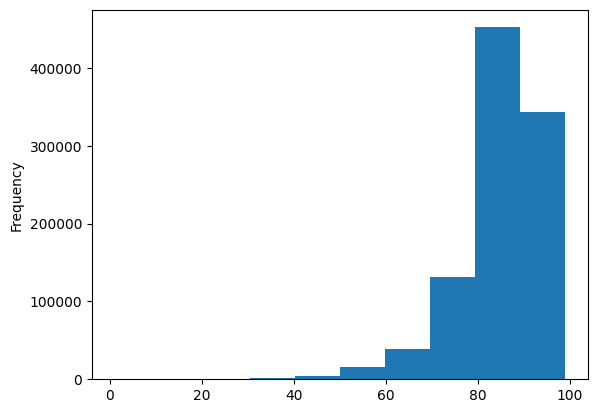

In [7]:
data['BirthYear'].plot(kind="hist")

Now the birth year almost looks okay, But one thing to check is year which are less than 15, which either results in customers with age near to 15 if they born in 1915 or earlier or they must be customers who born after 2000 whose age would be around 15 years or less. In either case they can be treated as outliers and removed.



<Axes: ylabel='Frequency'>

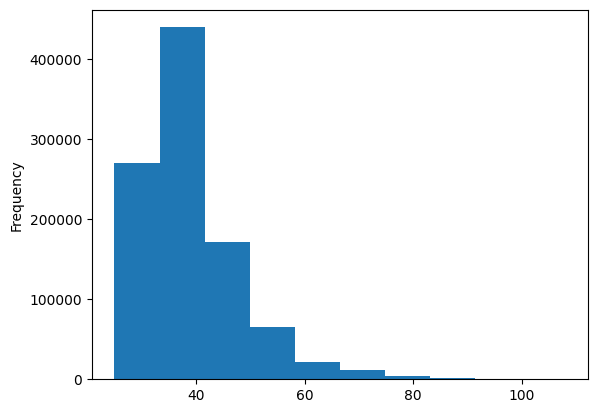

In [8]:
data = data[data['BirthYear']>15]
data['BirthYear'] = data['BirthYear']+1900
data['Age'] = 2024 - data['BirthYear']

# Lets plot the age
data['Age'].plot(kind="hist")

We can see some customers age greater than 90. Lets remove them as outliers. (In the real data these can be valid accounts but still be outliers. People with that age might have pension transactions in their accounts. 

In [9]:
data = data[data['Age']<90]
data.drop(columns=['CustomerDOB','TransactionTime','BirthYear'],inplace=True)

#### **Transaction Frequency**
This gives is the idea on how frequent the customers are using the services of the bank.  
We can group the dataset by CustomerID and calculate the frequency of transactions over different time periods (for time period of an year)

In [10]:
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
transactions = data.groupby('CustomerID')['TransactionID'].nunique().reset_index()

trans_counts = transactions['TransactionID'].value_counts()
category_percentages = transactions['TransactionID'].value_counts(normalize=True) * 100

print(trans_counts)

/tmp/ipykernel_17/215932022.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])


TransactionID
1    710735
2    113286
3     14347
4      1353
5       108
6         6
Name: count, dtype: int64


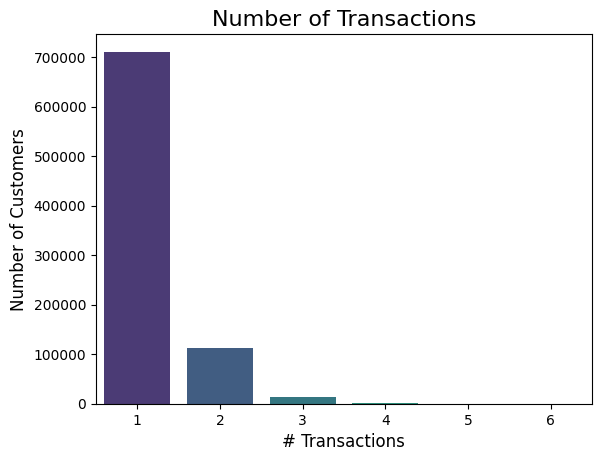

In [11]:
# Plotting a barplot using Seaborn

sns.barplot(x=trans_counts.index, y=trans_counts.values, palette='viridis')

plt.xlabel('# Transactions', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.title('Number of Transactions', fontsize=16)
plt.show()

Most of the customers have only 1 transactions made. Which covers 85% of the all customers.

And 1467 customers out of 839835 (0.17%) made more than 4 transactions. 

#### **Recency of Last Transaction:**

Measure how recent the last transaction was compared to the current date, giving insight into how active the customer is

Recency = CurrentDate - LastTransactionDate

In [12]:
data['TransactionDate'].min()

Timestamp('2016-01-08 00:00:00')

In [13]:
data['TransactionDate'].max()

Timestamp('2016-12-09 00:00:00')

In [14]:
## Lets create a recency to 2017 Jan 1st. Which will say how recent were the customer to the date Jan 1st of 2017

today_date = datetime(2017, 1, 1)

data['Recency'] = (today_date - data['TransactionDate']).dt.days
customer_recency = data.groupby('CustomerID')['Recency'].max().reset_index()


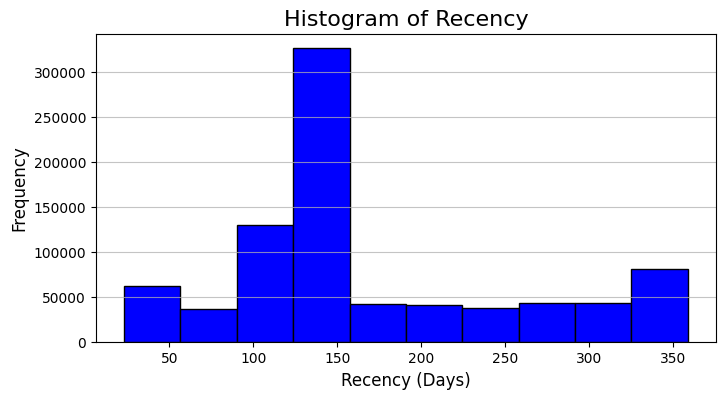

In [15]:
# Plotting the histogram using Matplotlib
plt.figure(figsize=(8, 4))  # Set the figure size
plt.hist(customer_recency['Recency'], bins=10, color='blue', edgecolor='black')  # Histogram with 10 bins
plt.xlabel('Recency (Days)', fontsize=12)  # X-axis label
plt.ylabel('Frequency', fontsize=12)        # Y-axis label
plt.title('Histogram of Recency', fontsize=16)  # Title of the plot
plt.grid(axis='y', alpha=0.75)  # Optional: Add gridlines for better readability
plt.show()  # Display the plot

So, there are customers who were active recently, but a significant number of customers have not been active for a long period.

Customers who were active for more than 200-360 days (more than 6 months) can be categorized as inactive (let's say) or churned customers.  
The customers who were active for 120 - 200 days are at high risk of churning but may not yet become inactive. So these are high-priority buckets for the banks to offer some benefits to avoid the further loss of customers.

Let's see and visualize these buckets as well.


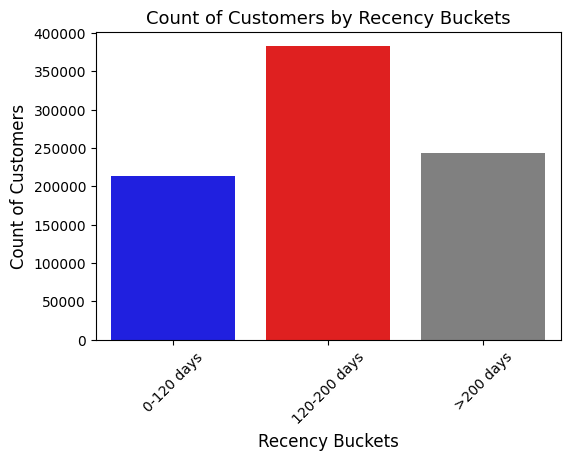

In [16]:
bins = [0, 120, 200, float('inf')]  # Define the bin edges
labels = ['0-120 days', '120-200 days', '>200 days']  # Define the labels for the bins

# Create a new column 'Recency_Bucket' based on the defined bins
customer_recency['Recency_Bucket'] = pd.cut(customer_recency['Recency'], bins=bins, labels=labels, right=False)

bucket_counts = customer_recency['Recency_Bucket'].value_counts()
colors = ['blue', 'red', 'grey']


plt.figure(figsize=(6, 4))  # Set the figure size
sns.barplot(x=bucket_counts.index, y=bucket_counts.values, palette=colors)
# Add labels and title
plt.xlabel('Recency Buckets', fontsize=12)
plt.ylabel('Count of Customers', fontsize=12)
plt.title('Count of Customers by Recency Buckets', fontsize=13)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()  # Display the plot

As we can see there are many customers at high risk of churning

#### **Average Transaction Amount**

In [17]:
data['Avg Transaction amnt'] = data.groupby('CustomerID')['TransactionAmount (INR)'].transform('sum')/data.groupby('CustomerID')['TransactionID'].transform('nunique')
avg_trans = data[['CustomerID','Avg Transaction amnt']].drop_duplicates()

avg_trans['Avg Transaction amnt'].describe()

count    839835.00
mean       1452.77
std        6041.69
min           0.00
25%         180.00
50%         474.50
75%        1175.00
max     1560034.99
Name: Avg Transaction amnt, dtype: float64

<Axes: >

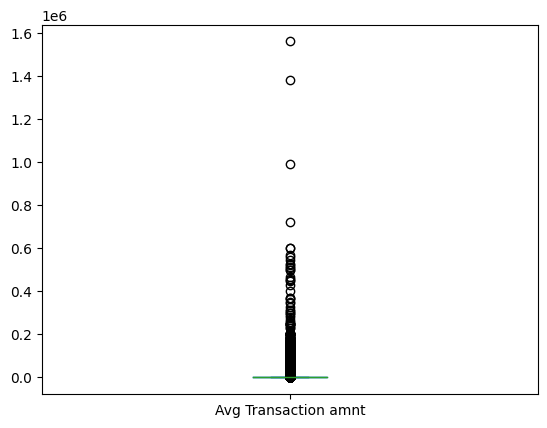

In [18]:
avg_trans['Avg Transaction amnt'].plot(kind='box')

As we can see,  the average transaction has a very long tail with some high extremes. These are not outliers but are some high transactions.

To have a better look at their distribution let's transform them and have a look at them.

<Axes: >

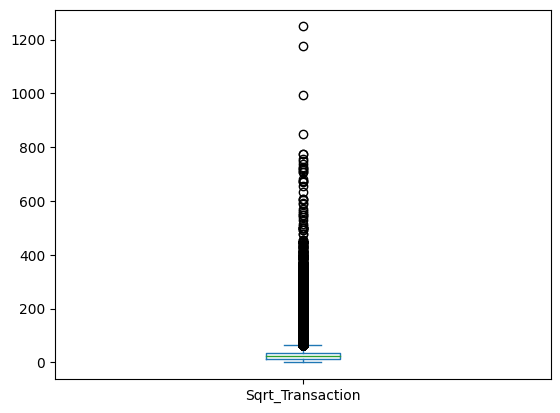

In [19]:
avg_trans['Sqrt_Transaction'] =  np.sqrt(avg_trans['Avg Transaction amnt'])
avg_trans['Sqrt_Transaction'].plot(kind='box')

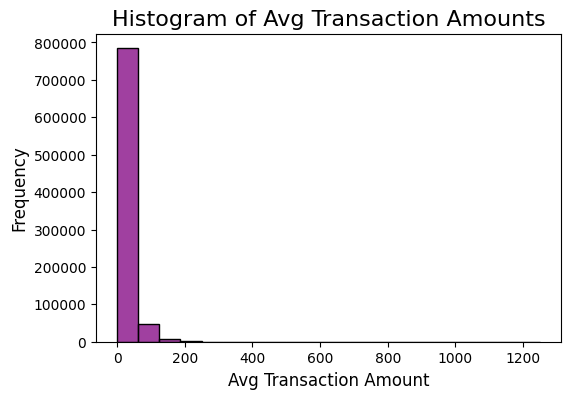

In [20]:
plt.figure(figsize=(6, 4))
sns.histplot(avg_trans['Sqrt_Transaction'], bins=20,  color="purple")
plt.title('Histogram of Avg Transaction Amounts', fontsize=16)
plt.xlabel('Avg Transaction Amount', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


As we can see the average transaction is right skewed, with some very high transactions made with very little frequency.

Let's look at the spending behaviour of active customers only

In [21]:
avg_trans = avg_trans.merge(customer_recency,on='CustomerID',how='left')

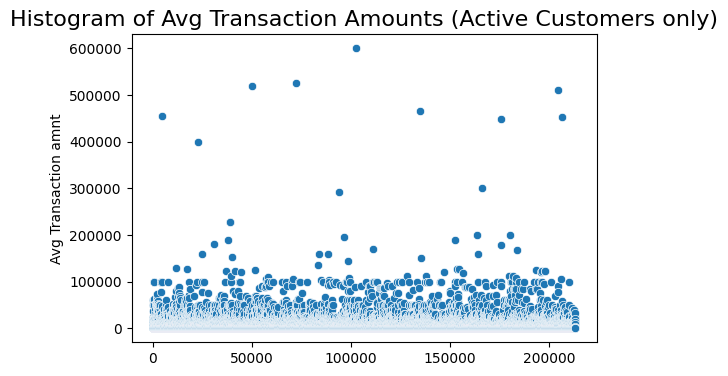

In [22]:
data_temp = avg_trans[avg_trans['Recency_Bucket']=='0-120 days'].reset_index()['Avg Transaction amnt']
plt.figure(figsize=(6, 4))
sns.scatterplot(data_temp)
plt.title('Histogram of Avg Transaction Amounts (Active Customers only)', fontsize=16)

plt.show()

#### **Transaction Variability**

 Measuring the standard deviation of transaction amounts for each customer. A high variability could indicate sporadic big purchases or unstable spending behavior.

In [23]:
## Lets look at only active customers

Active_customers = customer_recency[customer_recency['Recency_Bucket']=='0-120 days']['CustomerID']
freeq_customers = transactions[transactions['TransactionID']>1]['CustomerID']
Active_customers = list(set(Active_customers) & set(freeq_customers))


## Calculating the std of transaction amount by customer

trasn_std = data.groupby('CustomerID')['TransactionAmount (INR)'].std().reset_index()
active_cust_trans_std = trasn_std[trasn_std['CustomerID'].isin(Active_customers)]
active_cust_trans_std['TransactionAmount (INR)'].describe()

count     9590.00
mean      1461.12
std       5091.19
min          0.00
25%        142.13
50%        410.83
75%       1144.12
max     267438.72
Name: TransactionAmount (INR), dtype: float64

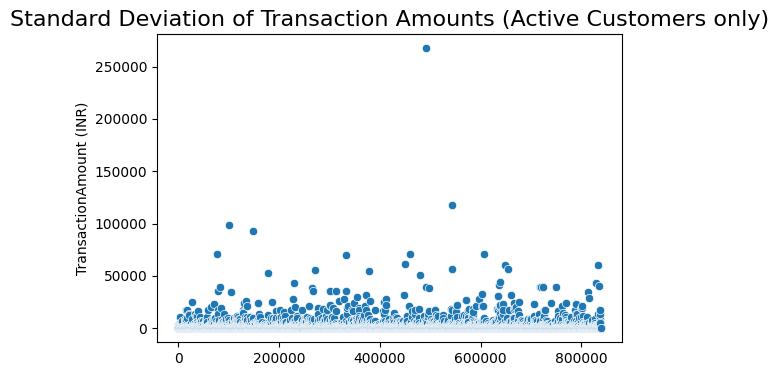

In [24]:
plt.figure(figsize=(6, 4))
sns.scatterplot(active_cust_trans_std['TransactionAmount (INR)'])
plt.title('Standard Deviation of Transaction Amounts (Active Customers only)', fontsize=16)

plt.show()

The plot gives us the idea that there are so many stable transaction customers and some unstable/high transaction customers as well.

#### **Balance Change**

We can calculate changes in balance after each transaction by looking at CustAccountBalance over time.  
The difference in balance could indicate whether the customer is saving, withdrawing, or topping up funds.

In [25]:
Active_customers = customer_recency[customer_recency['Recency_Bucket']=='0-120 days']['CustomerID']
freeq_customers = transactions[transactions['TransactionID']>2]['CustomerID']
Active_customers = list(set(Active_customers) & set(freeq_customers))

## As we have max of 6 trasnactions in the data, we will create 6 lag values of account balance feature. 
## These lag values gives us the time series view of account balance after each trasactions.
## With that done we will try to get an idea of whether amounts are withdrawn or saved over time


## Sorting and filtering the data for active customers.

balance_change_temp = data.sort_values(by=['CustomerID', 'TransactionDate'])
balance_change_temp = balance_change_temp[balance_change_temp['CustomerID'].isin(Active_customers)]


## Creating lag values columns

balance_change_temp['lag1_balance'] = balance_change_temp.groupby('CustomerID')['CustAccountBalance'].shift(1)
balance_change_temp['lag2_balance'] = balance_change_temp.groupby('CustomerID')['CustAccountBalance'].shift(2)
balance_change_temp['lag3_balance'] = balance_change_temp.groupby('CustomerID')['CustAccountBalance'].shift(3)
balance_change_temp['lag4_balance'] = balance_change_temp.groupby('CustomerID')['CustAccountBalance'].shift(4)
balance_change_temp['lag5_balance'] = balance_change_temp.groupby('CustomerID')['CustAccountBalance'].shift(5)
balance_change_temp['lag6_balance'] = balance_change_temp.groupby('CustomerID')['CustAccountBalance'].shift(6)


In [26]:
balance_change_temp.head()

,TransactionID,CustomerID,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionAmount (INR),Age,Recency,Avg Transaction amnt,lag1_balance,lag2_balance,lag3_balance,lag4_balance,lag5_balance,lag6_balance
202396,T202397,C1017576,M,GURGAON,4629.37,2016-09-08,2165.00,33.00,115,1754.00,NaN,NaN,NaN,NaN,NaN,NaN
268369,T268370,C1017576,M,HATHRAS,9129.33,2016-12-08,100.00,32.00,24,1754.00,4629.37,NaN,NaN,NaN,NaN,NaN
913326,T913327,C1017576,M,BAMBOLIM,246292.37,2016-12-09,2997.00,47.00,23,1754.00,9129.33,4629.37,NaN,NaN,NaN,NaN
312810,T312811,C1018516,F,DIMAPUR,3838.67,2016-10-08,290.00,31.00,85,1345.33,NaN,NaN,NaN,NaN,NaN,NaN
926726,T926727,C1018516,M,AHMEDABAD,175.13,2016-11-09,630.00,30.00,53,1345.33,3838.67,NaN,NaN,NaN,NaN,NaN


Now we can delete the unwanted rows which are initial rows and retain only last transaction row which will have all the transactions made over time


In [27]:
transaction_data = balance_change_temp.drop_duplicates(subset='CustomerID',keep='last')

Now we will check the trend of these balance amount and see if type of account they belong to.

In [28]:
# Define a function to check the trend
def check_trend(row):
    lags = [row['lag6_balance'], row['lag5_balance'], row['lag4_balance'], 
            row['lag3_balance'], row['lag2_balance'], row['lag1_balance'],row['CustAccountBalance']]
    
    # Remove any NaN values if there are missing lags
    lags = [x for x in lags if pd.notnull(x)]
    
    # Check if all lag values are increasing
    if all(x < y for x, y in zip(lags, lags[1:])):
        return 'saving'
    
    # Check if all lag values are decreasing
    elif all(x > y for x, y in zip(lags, lags[1:])):
        return 'withdrawing'
    
    # If neither increasing nor decreasing, the trend is mixed
    else:
        return 'mixed'


In [29]:
# Apply the function to each row of the DataFrame
transaction_data['trend'] = transaction_data.apply(check_trend, axis=1)


/tmp/ipykernel_17/1502839711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_data['trend'] = transaction_data.apply(check_trend, axis=1)


In [30]:
transaction_data = transaction_data[['CustomerID','trend']]
transaction_data = transaction_data['trend'].value_counts().reset_index()


In [31]:
transaction_data

,trend,count
0,mixed,239
1,withdrawing,58
2,saving,51


<Axes: xlabel='trend', ylabel='count'>

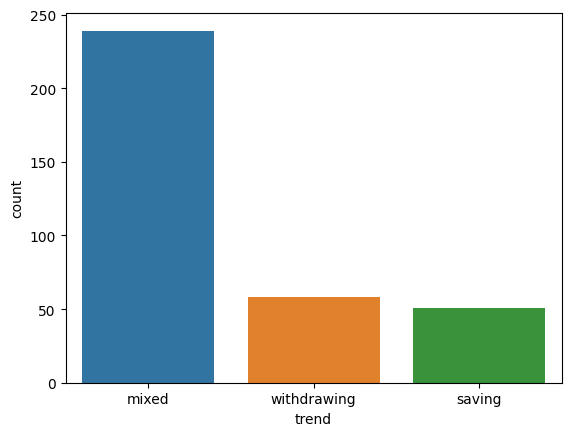

In [32]:
sns.barplot(x=transaction_data['trend'],y=transaction_data['count'])

As we can see there is a significant number of accounts that are used for both depositing and withdrawing which represents salary account types. Others that are only used for withdrawing and saving are fairly in the same range and are fewer in numbers

## RFM Analysis (Recency, Frequency, Monetary Value)

**This is a common technique in customer segmentation to categorize customers based on their transaction behavior.**    

**Recency**: When was their last transaction?  
**Frequency**: How often do they transact?  
**Monetary**: How much do they spend?  

Now that we have already created all 3 Recency, Frequency, and Monetary features, let's dive into further analysis.  
Let's assign some scores for all 3 features and then create the different buckets of feature values with combinations to segment the customers.  
Let's start with creating the appropriate dataset we need.

In [33]:
## Creating a dataframe to keep all customers info:

RFM_data = pd.DataFrame()
all_customers = data['CustomerID'].unique()

RFM_data['CustomerID'] = all_customers


## Merging with Transactions data to get # unique transactions made
RFM_data = RFM_data.merge(transactions,on='CustomerID',how='left')
RFM_data.rename(columns={'TransactionID':'Frequency'},inplace=True)


## Merging with Recency data to get recency of each customer
RFM_data = RFM_data.merge(customer_recency[['CustomerID','Recency']],on='CustomerID',how='left')


## Merging with Avg transactio data to get monetary value of customers
RFM_data = RFM_data.merge(avg_trans[['CustomerID','Avg Transaction amnt']],on='CustomerID',how='left')

In [34]:
RFM_data.head()

,CustomerID,Frequency,Recency,Avg Transaction amnt
0,C5841053,1,328,25.00
1,C2142763,1,328,27999.00
2,C4417068,1,328,459.00
3,C5342380,2,328,1469.20
4,C9031234,1,328,1762.50


Let's assign scores for each of RFM features for each customers.

We will divide the data into 5 different even quantiles and assign scores for each of those quantiles from 1 to 5 (5 being highest)

In [35]:

# Assign R, F, and M scores by dividing into quintiles
RFM_data['R_Score'] = pd.qcut(RFM_data['Recency'], 5, labels=[5, 4, 3, 2, 1], duplicates='drop')

RFM_data['F_Score'] = pd.cut(RFM_data['Frequency'], bins=5, labels=[1, 2, 3, 4, 5])


## Since Avg Transaction is highly skewed, will transform the value first and then cut them into bins
RFM_data['LogMonetaryValue'] = np.log1p(RFM_data['Avg Transaction amnt'])
RFM_data['M_Score'] = pd.qcut(RFM_data['LogMonetaryValue'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')


In [36]:
# Combine R, F, and M scores into a single RFM Score
RFM_data['RFM_Score'] = RFM_data['R_Score'].astype(str) + RFM_data['F_Score'].astype(str) + RFM_data['M_Score'].astype(str)

#### **We can now segment customers based on these RFM scores. Here are some commonly used segments:**

**Best Customers**: Customers with an high RFM (highest Recency, Frequency, and Monetary).  
**Loyal Customers**: Customers with high Frequency and Monetary scores, but possibly lower Recency.  
**At-Risk Customers**: Previously high-value customers (high Frequency and Monetary scores) but haven't transacted recently.  
**New Customers**: Customers with high Recency but low Frequency and Monetary scores.  
**Hibernating Customers**: Customers with low Recency, Frequency, and Monetary scores.  
**Big Spenders**: Customers with high Monetary scores but possibly low Recency and Frequency.  
**Other**: A catch-all for any customer who doesn’t fit into the predefined segments.  

In [37]:
def rfm_segment(df):
    if df['R_Score'] in ['4', '5'] and df['F_Score'] in ['4', '5'] and df['M_Score'] in ['4', '5']:
        return 'Best Customers'
    elif df['R_Score'] in ['3','4', '5'] and df['F_Score'] in ['4', '5'] and df['M_Score'] in ['3','4', '5']:
        return 'Loyal Customers'
    elif df['R_Score'] in ['1','2'] and df['F_Score'] in ['4', '5'] and df['M_Score'] in ['3','4', '5']:
        return 'At-Risk Customers'
    elif df['R_Score'] in ['4','5'] and df['F_Score'] in ['1','2'] and df['M_Score'] in ['1','2']:
        return 'New Customers'
    elif df['R_Score'] in ['1','2'] and df['F_Score'] in ['1','2'] and df['M_Score'] in ['1','2','3']:
        return 'Hibernating Customers'
    elif df['M_Score'] in ['4', '5'] and df['R_Score'] in ['1', '2'] and df['F_Score'] in ['1', '2']:
        return 'Big Spenders'
    else:
        return 'Other'

In [38]:
# Apply the segment labeling function to each row
# RFM_data['RFM_Score'] = RFM_data['RFM_Score'].astype(str)
RFM_data['R_Score'] = RFM_data['R_Score'].astype(str)
RFM_data['F_Score'] = RFM_data['F_Score'].astype(str)
RFM_data['M_Score'] = RFM_data['M_Score'].astype(str)

RFM_data['Segment'] = RFM_data.apply(rfm_segment, axis=1)


In [39]:
RFM_data.head()

,CustomerID,Frequency,Recency,Avg Transaction amnt,R_Score,F_Score,LogMonetaryValue,M_Score,RFM_Score,Segment
0,C5841053,1,328,25.00,1,1,3.26,1,111,Hibernating Customers
1,C2142763,1,328,27999.00,1,1,10.24,5,115,Big Spenders
2,C4417068,1,328,459.00,1,1,6.13,3,113,Hibernating Customers
3,C5342380,2,328,1469.20,1,1,7.29,4,114,Big Spenders
4,C9031234,1,328,1762.50,1,1,7.48,5,115,Big Spenders


In [40]:
print(RFM_data[['CustomerID', 'RFM_Score', 'Segment']])


       CustomerID RFM_Score                Segment
0        C5841053       111  Hibernating Customers
1        C2142763       115           Big Spenders
2        C4417068       113  Hibernating Customers
3        C5342380       114           Big Spenders
4        C9031234       115           Big Spenders
...           ...       ...                    ...
839830   C5028150       515                  Other
839831   C1034220       514                  Other
839832   C8020229       514                  Other
839833   C6459278       513                  Other
839834   C6420483       514                  Other

[839835 rows x 3 columns]


In [41]:
segments_count = RFM_data['Segment'].value_counts().reset_index()
segments_count

,Segment,count
0,Other,372641
1,Hibernating Customers,186871
2,New Customers,146598
3,Big Spenders,133622
4,At-Risk Customers,90
5,Loyal Customers,12
6,Best Customers,1


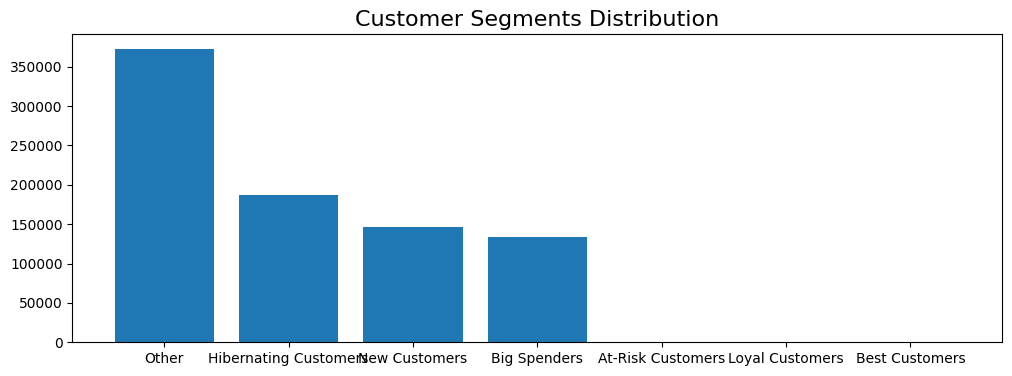

In [42]:

plt.figure(figsize=(12, 4))
plt.bar(segments_count['Segment'],segments_count['count'])
# plt.legend(segments_count['Segment'], title="Segments", loc="best")
plt.title('Customer Segments Distribution', fontsize=16)
# plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

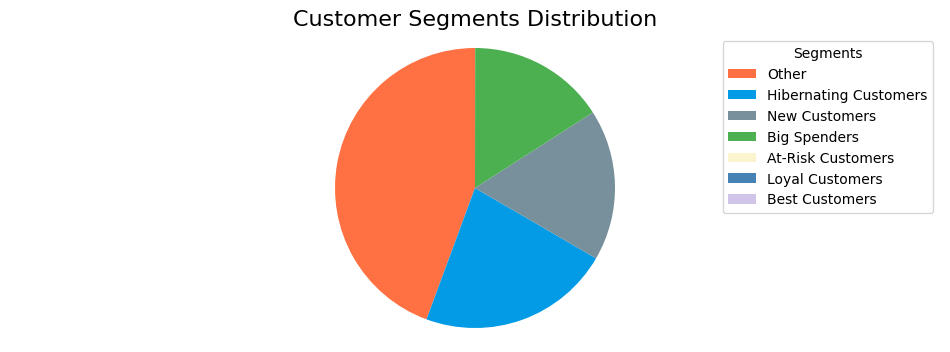

In [43]:
# Define custom colors for each segment
colors = ['#ff7043',  # Other 
          '#039be5',  # Big spenders
          '#78909c',  # Hibernating
          '#4caf50',  # New
          '#fcf3cf',  # At Risk
          '#4682B4',  # 
          '#d1c4e9']  # 


plt.figure(figsize=(12, 4))
plt.pie(segments_count['count'], startangle=90, colors=colors)
plt.legend(segments_count['Segment'], title="Segments", loc="best")
plt.title('Customer Segments Distribution', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## Customer Profiling


#### 1. Best Customers (High Frequency, Recency and Monetary Scores)

Profile:
Behavior: These customers are the most engaged. They purchase frequently, spend the most, and have recently made a transaction.  
Value: High-value customers in terms of profitability and long-term loyalty.

#### 2. Loyal Customers (High Frequency and Monetary Scores)

Profile:
Behavior: These customers purchase frequently and spend significantly, but may not have made a very recent transaction.  
Value: They are steady and reliable customers who can be nurtured into Best Customers with the right engagement.

#### 3. At-Risk Customers (High Frequency and Monetary, Low Recency)

Profile: These customers were previously highly engaged, but they haven’t transacted recently.  
Value: They were once valuable but are now at risk of churning. They have to be re-engaged before they leave permanently.

#### 4. New Customers (High Recency, Low Frequency and Monetary)

Profile: These are recent customers who have made a small or one-time purchase.  
Value: They are early in their journey and represent potential growth opportunities, but are still unproven.

#### 5. Hibernating Customers (Low Recency, Frequency, and Monetary Scores)

Profile: These customers have had minimal interaction with the bank. They are close to being considered lost.
Value: Low current value, but it’s worth trying a reactivation strategy if banks can identify what went wrong.

#### 6. Big Spenders (High Monetary, Low Recency and Frequency)

Profile: These customers may not transact often, but when they do, they transact significantly.  
Value: High potential value because they make large transactions. 

#### 7. Lost Customers (Low Recency, Frequency, and Monetary)


Profile: These customers haven’t engaged with the bank for a long time and are close to being considered churned.  
Value: Low value unless they can be reactivated, but their past engagement history suggests they might not come back easily.

#### 8. Other Segments (Mixed RFM Scores)

Profile: Customers with mid-range RFM scores may have moderate engagement. They’re not too recent, frequent, or high spenders, but they’re also not entirely dormant.  
Value: These customers could go either way – they might turn into more valuable customers or lapse into inactivity if not nurtured.


## Conclusion

In this project, we performed a detailed **Exploratory Data Analysis (EDA)** followed by **RFM analysis** to segment the bank’s customer base. By evaluating customers on the three dimensions of **Recency**, **Frequency**, and **Monetary value**, we were able to create meaningful customer segments, each with distinct behavioral characteristics.

These insights provide actionable information that can help the bank refine its customer engagement strategies. High-value and loyal customers can be targeted for retention efforts, while infrequent or low-value customers may benefit from re-engagement campaigns. RFM segmentation not only highlights the value of each customer group but also enables more personalized marketing efforts, which can lead to improved customer satisfaction and profitability.

Future work could involve tracking how customers move between segments over time and integrating additional behavioral or demographic data for a more comprehensive view of customer preferences.


# **Thank You !!!!!**